In [1]:
!pip install transformers

  Using cached https://files.pythonhosted.org/packages/ae/05/c8c55b600308dc04e95100dc8ad8a244dd800fe75dfafcf1d6348c6f6209/transformers-3.1.0-py3-none-any.whl
Processing /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45/sacremoses-0.0.43-cp36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/80/83/8b9fccb9e48eeb575ee19179e2bdde0ee9a1904f97de5f02d19016b8804f/tokenizers-0.8.1rc2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/a4/d0a884c4300004a78cca907a6ff9a5e9fe4f090f5d95ab341c53d28cbc58/sentencepiece-0.1.91-cp36-cp36m-manylinux1_x86_64.whl


' !pip install transformers\n!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz \n!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt \n!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/config.json \n!tar -xzvf pytorch_weights.tar.gz\n!mv config.json pytorch/.\n!mv vocab.txt pytorch/. '

In [2]:
# --> for cleaning:
!pip install langdetect

In [72]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelWithLMHead
from google.cloud import bigquery
from langdetect import detect
from google.colab import auth,drive
import pandas as pd

In [4]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
auth.authenticate_user()

In [6]:
project_id = 'tlac-vision'

client = bigquery.Client(project=project_id)
df = client.query('''
  SELECT
    *
  FROM
    `tlac-vision.book_backend.train_categories`
''').to_dataframe()

In [7]:
# --> sorting dataframe by book category, from A to Z
df = df.sort_values(['category'], ascending=True)

# --> dropping duplicate rows
df = df.drop_duplicates(['title']).reset_index(drop=True)

In [8]:
# --> deleting results that are in other languages different to spanish
df['language'] = ""
for index, row in df.iterrows():
    row['language'] = detect(row['description'])
df = df[df.language == 'es']

cat_count = df.iloc[:,0:2].groupby('category').count().rename(columns={'title': 'count'})  # total of registers per category

In [9]:
# --> 75% of data is for training
cat_count['training'] = round(0.75 * cat_count['count'], 0)

# --> organizing indexes to split data
cat_count['acum'] = cat_count['count'].cumsum()
cat_count['init_idx'] = cat_count['acum'] - cat_count['count']
cat_count['train_idx'] = cat_count['init_idx'] + cat_count['training']

In [10]:
# --> creating training set with 75% of data per category
train_set = pd.DataFrame(data=None, columns=df.columns)
for i in range(len(cat_count)):
    i_idx = int(cat_count.iloc[i, 3])
    f_idx = int(cat_count.iloc[i, 4])
    train_set = train_set.append(df.iloc[i_idx:f_idx, :])

train_set_f = train_set.loc[:, ['category', 'description']]
train_set_f=train_set_f.reset_index(drop=True)
#train_set_f['is_valid']=False
train_set_f.iloc[0:5,]

,category,description
0,anthropology,"""Después de 60 años como misionero en el Perú ..."
1,anthropology,A lo largo de los últimos cien años la antropo...
2,anthropology,"En este libro, uno de los principales teoricos..."
3,anthropology,"El fuego, presente ya en los inicios del proce..."
4,anthropology,Este ambicioso tratado sobre el fenómeno relig...


In [11]:
# --> creating validation set with 25% of data per category
val_set = pd.DataFrame(data=None, columns=df.columns)
for i in range(len(cat_count)):
    i_idx = int(cat_count.iloc[i, 4])
    f_idx = int(cat_count.iloc[i, 2])
    val_set = val_set.append(df.iloc[i_idx:f_idx, :])

val_set_f = val_set.loc[:, ['category', 'description']]
val_set_f=val_set_f.reset_index(drop=True)
#val_set_f['is_valid']=True
val_set_f.iloc[0:5,]

,category,description
0,anthropology,Antología preparada en torno al axolote (o axó...
1,anthropology,Sirviéndose de los recursos metodológicos prop...
2,anthropology,Este trabajo consta de dos partes bien diferen...
3,anthropology,"Los problemas de la bioética no solo son, en l..."
4,anthropology,"La ANTROPOLOGÍA kantiana, más que en la divers..."


In [65]:
id_label = dict(zip(train_labels.unique(), range(0,11))) #categorical labels to numerical
train_labels,train_text= train_set_f['category'].map(id_label),train_set_f['description']
val_labels,val_text= val_set_f['category'].map(id_label),val_set_f['description']

In [13]:
# --> create the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
model = AutoModelWithLMHead.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

/usr/local/lib/python3.6/dist-packages/transformers/modeling_auto.py:821: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Some weights of BertForMaskedLM were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f338b699390>]],
      dtype=object)

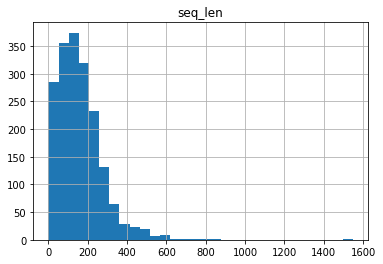

In [14]:
# --> distribution of the sequence lengths(number of words) in the train set to find the padding length 
seq_len = pd.DataFrame([len(i.split()) for i in train_set_f['description']],columns=['seq_len'])
seq_len.hist(bins = 30)

In [15]:
def intervals():
  to_return=list()
  j=0
  for i in range(0,32):
    to_return.append(j)
    j+=50

  return to_return
    
ranges = intervals()

sl_grouped=seq_len.groupby(pd.cut(seq_len.seq_len, ranges)).count().rename(columns={'seq_len':''})
sl_grouped=sl_grouped.add_suffix('count').reset_index()
sl_grouped['%']=round(100*sl_grouped['count'].cumsum()/sl_grouped['count'].sum(),3)

sl_grouped.iloc[0:10,:] 

,seq_len,count,%
0,"(0, 50]",267,14.386
1,"(50, 100]",350,33.244
2,"(100, 150]",357,52.478
3,"(150, 200]",315,69.450
4,"(200, 250]",244,82.597
5,"(250, 300]",148,90.571
6,"(300, 350]",68,94.235
7,"(350, 400]",35,96.121
8,"(400, 450]",23,97.360
9,"(450, 500]",24,98.653


In [68]:
# --> tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 250,
    padding='max_length',
    truncation=True
)

# --> tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 250,
    padding='max_length',
    truncation=True
)

In [69]:
# --> sample data for BETO
text = ["esta es una prueba","estoy haciendo una prueba"]
sent_id = tokenizer.batch_encode_plus(text, padding=True) # encode text
print(sent_id)

{'input_ids': [[4, 1149, 1028, 1091, 3610, 5], [4, 1435, 2194, 1091, 3610, 5]], 'token_type_ids': [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


In [73]:
# --> convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [74]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)